---
# title: "LLM-scCurator Option B (Advanced): Run from R via reticulate"
output:
  html_document:
    toc: true
    toc_depth: 3
    number_sections: true
---

## Overview

This tutorial shows how to run LLM-scCurator from R using reticulate (calling Python from within an R session).

> **Environment note (official Docker)**:
    If you are using the official LLM-scCurator Docker image, the required R + Python environment is already installed and configured. You can skip most installation steps and focus on the workflow below.

You will:
1. Confirm that your R session can access the bundled Python environment via *reticulate*.
2. Load a small demo dataset (PBMC3k) *or* load your own exported data
3. Ensure `adata.X` is **log1p-normalized** (required by LLM-scCurator).
4. Run LLM-scCurator:
    * feature curation (curate_features)
    * optional LLM-based labeling (annotate) if an API key is available
5. Export a cluster→label mapping CSV that you can re-import into Seurat.


> **Recommendation**
> For most users, we recommend Option A: export from Seurat → run in Python (Colab or local).
> Option B exists for advanced users who prefer to stay in an R-centric workflow and are comfortable with reticulate.

---

## Requirements

### API key (optional but recommended)

- If you only want to test **local feature curation**, an API key is not required.
- If you want to run **LLM-based annotation** (hierarchical discovery or per-cluster labeling), you need an API key.


## Setup: R + Python environment checks

In [1]:
library(reticulate)
library(Seurat)
library(SingleCellExperiment)
library(Matrix)
library(data.table)
library(ggplot2)

cat("R version:\n")
print(R.version.string)

cat("\nreticulate config:\n")
print(py_config())

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
 

R version:
[1] "R version 4.5.2 (2025-10-31)"

reticulate config:
python:         /opt/conda/envs/py/bin/python
libpython:      /opt/conda/envs/py/lib/libpython3.12.so
pythonhome:     /opt/conda/envs/py:/opt/conda/envs/py
version:        3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:16:53) [GCC 14.3.0]
numpy:          /opt/conda/envs/py/lib/python3.12/site-packages/numpy
numpy_version:  2.3.5

NOTE: Python version was forced by RETICULATE_PYTHON


## Verify Python dependencies

In [2]:
have_module <- function(mod) {
tryCatch({ py_module_available(mod) }, error = function(e) FALSE)
}

mods <- c("scanpy", "anndata", "pandas", "scipy", "llm_sc_curator")
status <- setNames(vapply(mods, have_module, logical(1)), mods)
print(status)


        scanpy        anndata         pandas          scipy llm_sc_curator 
          TRUE           TRUE           TRUE           TRUE           TRUE 


## Create a demo Seurat object
If you already have your own Seurat object, replace this cell with pbmc <- readRDS("your_object.rds").

Detected 10x data_dir: pbmc3k/filtered_gene_bc_matrices/hg19

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 119935

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8658
Number of communities: 9
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:02:56 UMAP embedding parameters a = 0.9922 b = 1.112

19:02:56 Read 2638 rows and found 20 numeric columns

19:02:56 Using Annoy for neighbor search, n_neighbors = 30

19:02:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:02:56 Writing NN index file to temp file /tmp/Rtmpd5V4YC/file295e3179923f

19:02:56 Searching Annoy index using 1 thread, search_k = 3000

19:02:57 Annoy recall = 100%

19:02:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

✅ Wrote: /work/pbmc3k_seurat.rds 


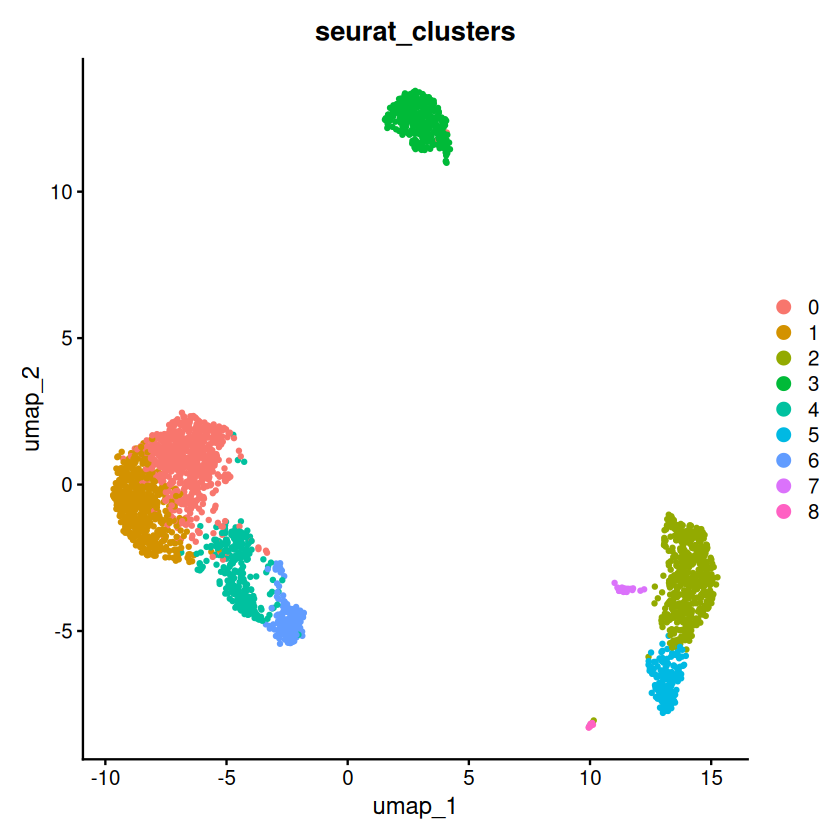

In [3]:
# ---- Download PBMC3k (10x) ----
url <- "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
dest <- "pbmc3k.tar.gz"
exdir <- "pbmc3k"

# 1) Download without wget (works in most Docker/Jupyter setups)
options(download.file.method = "libcurl")

ok <- tryCatch({
  download.file(url, destfile = dest, mode = "wb", quiet = TRUE)
  TRUE
}, error = function(e) {
  message("download.file() failed: ", e$message)
  FALSE
})

if (!ok || !file.exists(dest) || is.na(file.info(dest)$size) || file.info(dest)$size < 1e6) {
  stop("PBMC3k download failed (file missing or too small). Network access or SSL may be blocked.")
}

# 2) Extract
dir.create(exdir, showWarnings = FALSE, recursive = TRUE)
untar(dest, exdir = exdir)

# 3) Auto-detect the 10x directory that contains matrix.mtx
mtx <- list.files(exdir, pattern = "matrix.mtx", recursive = TRUE, full.names = TRUE)
if (length(mtx) < 1) {
  stop("Extraction succeeded but matrix.mtx was not found. Check the tar contents.")
}
data_dir <- dirname(mtx[1])
message("Detected 10x data_dir: ", data_dir)

# 4) Read 10x
counts <- Read10X(data.dir = data_dir)

pbmc <- CreateSeuratObject(counts = counts, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# ---- Standard Seurat workflow (light) ----
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:20)
pbmc <- FindClusters(pbmc, resolution = 0.5)
pbmc <- RunUMAP(pbmc, dims = 1:20)

# Pick an output directory that exists (Colab: /content, Docker: /work, fallback: current dir)
outdir <- if (dir.exists("/content")) {
  "/content"
} else if (dir.exists("/work")) {
  "/work"
} else {
  "."
}

# Ensure outdir exists (safe even if it already exists)
rds_path <- file.path(outdir, "pbmc3k_seurat.rds")
saveRDS(pbmc, rds_path)
cat("✅ Wrote:", rds_path, "\n")

DimPlot(pbmc, group.by = "seurat_clusters")


In [4]:
# ---- 1) Seurat -> SingleCellExperiment ----
pbmc_sce <- Seurat::as.SingleCellExperiment(pbmc, assay = "RNA")

# ---- 2) Ensure cluster column is stored as string in colData ----
if ("seurat_clusters" %in% colnames(colData(pbmc_sce))) {
  colData(pbmc_sce)$seurat_clusters <- as.character(colData(pbmc_sce)$seurat_clusters)
} else {
  # fallback: use Idents(pbmc) if seurat_clusters is not present
  colData(pbmc_sce)$seurat_clusters <- as.character(Idents(pbmc))
}

# ---- 3) Export raw counts (recommended) ----
cnt <- as(counts(pbmc_sce), "dgCMatrix")
Matrix::writeMM(cnt, file.path(outdir, "counts.mtx"))

# ---- 4) Export log1p-normalized expression for adata.X ----
# LLM-scCurator expects log1p-normalized expression in adata.X.
# Use logcounts if available; otherwise compute log1p(CP10K) from counts.
if ("logcounts" %in% assayNames(pbmc_sce)) {
  lx <- logcounts(pbmc_sce)
} else {
  message("logcounts not found in SCE; computing log1p(CP10K) from counts.")
  libsize <- Matrix::colSums(cnt)
  libsize[libsize == 0] <- 1
  lx <- t(t(cnt) / libsize) * 1e4
  lx <- log1p(lx)
}
lx <- as(lx, "dgCMatrix")
Matrix::writeMM(lx, file.path(outdir, "logcounts.mtx"))

# ---- 5) Export features (genes) ----
genes <- data.table(gene = rownames(pbmc_sce))
fwrite(genes, file.path(outdir, "features.tsv"), sep = "\t", col.names = FALSE)

# ---- 6) Export obs (cell metadata) ----
meta <- as.data.frame(colData(pbmc_sce))
meta$cell_id <- rownames(meta)
meta <- meta[, c("cell_id", setdiff(colnames(meta), "cell_id")), drop = FALSE]
fwrite(meta, file.path(outdir, "obs.csv"))

cat("✅ Exported folder:", outdir, "\n")
cat("   - counts.mtx (raw)\n")
cat("   - logcounts.mtx (log1p-normalized; use as adata.X)\n")
cat("   - features.tsv\n")
cat("   - obs.csv\n")

NULL

NULL

✅ Exported folder: /work 
   - counts.mtx (raw)
   - logcounts.mtx (log1p-normalized; use as adata.X)
   - features.tsv
   - obs.csv


In [5]:
# ---- Python modules ----
sc  <- import("scanpy", convert = FALSE)
io  <- import("scipy.io", convert = FALSE)
np <- import("numpy", convert = FALSE)
pd  <- import("pandas", convert = FALSE)

# --- base dir where counts.mtx exists ---
base <- outdir

# --- read matrices (features x cells) -> transpose to (cells x genes) ---
X <- io$mmread(file.path(base, "logcounts.mtx"))$tocsr()$transpose()
X_cnt <- io$mmread(file.path(base, "counts.mtx"))$tocsr()$transpose()

# --- read obs/var ---
var <- pd$read_csv(file.path(base, "features.tsv"),
                   sep = "\t", header = NULL, names = list("gene"))

obs <- pd$read_csv(file.path(base, "obs.csv"))$set_index("cell_id")
obs[["seurat_clusters"]] <- obs[["seurat_clusters"]]$astype("str")$str$replace("\\.0$", "", regex = TRUE)

var_df <- pd$DataFrame(index = var[["gene"]]$values)

adata <- sc$AnnData(X = X, obs = obs, var = var_df)

# raw counts to layers['counts']
py_set_item(adata$layers, "counts", X_cnt)

print(adata)
cat("layer keys:", paste(py_to_r(adata$layers$keys()), collapse = ", "), "\n")

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident'
    layers: 'counts'
layer keys: KeysView(Layers with keys: counts) 


In [6]:
# HVG selection
sc$pp$highly_variable_genes(
  adata,
  n_top_genes = 2000L,
  flavor = "seurat",
  subset = FALSE
)

# Check how many HVGs were selected
hv <- adata$var[["highly_variable"]]
# hv is a Python array-like; convert to R vector if needed
hv_r <- py_to_r(hv)
sum(hv_r, na.rm = TRUE)

None

[1] 2000

## Run LLM-scCurator, noise masking and Gini-informed distillation

In [7]:
ACCURACY_MODE <- FALSE  # FALSE = cheaper/faster

MODEL_NAME <- if (ACCURACY_MODE) "models/gemini-2.5-pro" else "models/gemini-2.0-flash"
cat("Using model:", MODEL_NAME, "\n")


Using model: models/gemini-2.0-flash 


In [8]:
lsc <- import("llm_sc_curator", convert = FALSE)
genai <- import("google.generativeai", convert = FALSE)

GEMINI_API_KEY <- "YOUR_KEY_HERE"

In [10]:
# Curator Initialize
curator = lsc$LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator$set_global_context(adata)

None

In [11]:
# -----------------------------
# 1) Choose a cluster (first sorted cluster id)
# -----------------------------
clusters_py <- adata$obs[["seurat_clusters"]]$astype("str")$unique()
clusters_r  <- sort(py_to_r(clusters_py))
cluster_name <- clusters_r[1]
cat("cluster_name =", cluster_name, "\n")

# -----------------------------
# 2) Standard DE: Target vs Rest (robust; no pandas where/inplace tricks)
# -----------------------------
N_GENES <- 50L
TMP <- "__tmp_binary__"

# Make a Target/Rest vector in R
cl <- py_to_r(adata$obs[["seurat_clusters"]]$astype("str")$tolist())
tmp <- ifelse(cl == as.character(cluster_name), "Target", "Rest")

# Assign it into pandas DataFrame safely: adata.obs[TMP] = tmp
py_set_item(adata$obs, TMP, r_to_py(tmp))

# (Optional) sanity check
# print(py_to_r(adata$obs$columns$tolist()))
# print(table(tmp))

# Run DE: Target vs Rest
sc$tl$rank_genes_groups(
  adata,
  groupby  = TMP,
  groups   = list("Target"),
  reference = "Rest",
  method   = "wilcoxon",
  use_raw  = FALSE
)

df_std <- sc$get$rank_genes_groups_df(adata, group = "Target")
genes_std <- py_to_r(df_std[["names"]]$head(N_GENES)$tolist())

# Drop TMP column (inplace)
adata$obs$drop(columns = list(TMP), inplace = TRUE, errors = "ignore")

# -----------------------------
# 3) Curated: LLM-scCurator
# -----------------------------
genes_cur_py <- curator$curate_features(
  adata,
  group_col    = "seurat_clusters",
  target_group = as.character(cluster_name),
  n_top        = N_GENES,
  use_statistics = TRUE
)
genes_cur <- py_to_r(genes_cur_py)

cat("genes_std len =", length(genes_std), "\n")
cat("genes_cur len =", length(genes_cur), "\n")

# show top few
cat("\nTop standard genes:\n", paste(head(genes_std, 10), collapse = ", "), "\n", sep="")
cat("\nTop curated genes:\n",  paste(head(genes_cur, 10), collapse = ", "), "\n", sep="")


cluster_name = 0 


None

None

genes_std len = 50 
genes_cur len = 50 

Top standard genes:
LTB, IL32, LDHB, CD3D, IL7R, TPT1, RPS12, CD3E, RPS25, RPS3

Top curated genes:
LTB, IL32, CD3D, CD3E, CD2, AQP3, GIMAP7, HINT1, GIMAP5, FYB


In [12]:
# -----------------------------
# Readable summary + comparison table
#   - Works even if genes_std is missing / NULL
#   - Preserves order of curated list for overlap/rescued
# -----------------------------

`%||%` <- function(x, y) if (is.null(x) || length(x) == 0) y else x

fmt_list <- function(title, genes, n = 10L, bullet = "\u2022") {
  genes <- unique(as.character(genes %||% character(0)))
  show_n <- min(as.integer(n), length(genes))
  body <- if (show_n > 0) {
    paste0(bullet, " ", genes[seq_len(show_n)], collapse = "\n")
  } else {
    paste0(bullet, " (empty)")
  }
  sprintf("%s (n=%d, showing %d)\n%s", title, length(genes), show_n, body)
}

pad <- function(xs, n = 15L) {
  xs <- as.character(xs %||% character(0))
  xs <- xs[seq_len(min(length(xs), n))]
  c(xs, rep("", max(0, n - length(xs))))
}

# --- Inputs (safe) ---
std <- unique(as.character(get0("genes_std", ifnotfound = character(0))))
cur <- unique(as.character(get0("genes_cur", ifnotfound = character(0))))

std_set <- unique(std)
cur_set <- unique(cur)

# Keep curated order for overlap/rescued
overlap <- cur[cur %in% std_set]
rescued <- cur[!(cur %in% std_set)]
dropped <- std[!(std %in% cur_set)]

cat(
  sprintf(
    "\nGene list summary: std=%d | curated=%d | shared=%d | rescued=%d | dropped=%d\n\n",
    length(std), length(cur), length(overlap), length(rescued), length(dropped)
  )
)

cat("🟦 ", fmt_list("Standard genes", std, n = 10L), "\n\n", sep = "")
cat("🟥 ", fmt_list("Curated genes",  cur, n = 10L), "\n\n", sep = "")
cat("➕ ", fmt_list("Rescued (curated-only)", rescued, n = 10L), "\n\n", sep = "")
cat("➖ ", fmt_list("Dropped (std-only)",  dropped, n = 10L), "\n\n", sep = "")

TOP <- 15L
df_view <- data.frame(
  cluster  = as.character(get0("cluster_name", ifnotfound = NA_character_)),
  rank     = seq_len(TOP),
  standard = pad(std, TOP),
  curated  = pad(cur, TOP),
  stringsAsFactors = FALSE
)

df_view



Gene list summary: std=50 | curated=50 | shared=8 | rescued=42 | dropped=42

🟦 Standard genes (n=50, showing 10)
• LTB
• IL32
• LDHB
• CD3D
• IL7R
• TPT1
• RPS12
• CD3E
• RPS25
• RPS3

🟥 Curated genes (n=50, showing 10)
• LTB
• IL32
• CD3D
• CD3E
• CD2
• AQP3
• GIMAP7
• HINT1
• GIMAP5
• FYB

➕ Rescued (curated-only) (n=42, showing 10)
• GIMAP5
• FYB
• CD3G
• ACAP1
• MAL
• PTPRCAP
• ITM2A
• GIMAP4
• TRAF3IP3
• ARL6IP5

➖ Dropped (std-only) (n=42, showing 10)
• LDHB
• IL7R
• TPT1
• RPS12
• RPS25
• RPS3
• RPS18
• JUNB
• RPS29
• EEF1A1



cluster,rank,standard,curated
<chr>,<int>,<chr>,<chr>
0,1,LTB,LTB
0,2,IL32,IL32
0,3,LDHB,CD3D
0,4,CD3D,CD3E
0,5,IL7R,CD2
0,6,TPT1,AQP3
0,7,RPS12,GIMAP7
0,8,CD3E,HINT1
0,9,RPS25,GIMAP5


## (Optinal) Run LLM-scCurator per cluster, zero-shot cell-type annotation

In [13]:
`%||%` <- function(x, y) if (is.null(x) || length(x) == 0 || is.na(x)) y else x

# -----------------------------
# helper: robust result parsing
# -----------------------------
ensure_json_result <- function(x) {
  out <- list(cell_type = NA_character_, confidence = NA_character_, reasoning = NA_character_)

  # 1) Python dict-like: x$get(...)
  try({
    ct <- x$get("cell_type")
    cf <- x$get("confidence")
    rs <- x$get("reasoning")
    if (!is.null(ct)) out$cell_type <- as.character(py_to_r(ct))
    if (!is.null(cf)) out$confidence <- as.character(py_to_r(cf))
    if (!is.null(rs)) out$reasoning <- as.character(py_to_r(rs))
    if (any(!is.na(unlist(out)))) return(out)
  }, silent = TRUE)

  # 2) If x is a JSON string, try jsonlite::fromJSON
  try({
    s <- as.character(py_to_r(x))
    if (is.character(s) && length(s) == 1 && grepl("^\\s*\\{", s)) {
      j <- jsonlite::fromJSON(s)
      out$cell_type <- as.character(j$cell_type %||% out$cell_type)
      out$confidence <- as.character(j$confidence %||% out$confidence)
      out$reasoning <- as.character(j$reasoning %||% out$reasoning)
      return(out)
    }
  }, silent = TRUE)

  # 3) Fallback: stringify
  try(out$reasoning <- as.character(py_to_r(x)), silent = TRUE)
  out
}

# -----------------------------
# 0) Preconditions (light checks)
# -----------------------------
has_counts <- TRUE
tryCatch({ adata$layers[["counts"]] }, error = function(e) { has_counts <<- FALSE })
if (!has_counts) {
  message("⚠ layers['counts'] not found. If use_statistics=TRUE returns empty genes, add raw counts into adata$layers[['counts']].")
}

# -----------------------------
# 1) Get cluster ids as strings (robust)
#   - convert to str
#   - drop trailing '.0' (common when clusters were numeric)
# -----------------------------
cl_vec <- py_to_r(adata$obs[["seurat_clusters"]]$astype("str")$tolist())
cl_vec <- gsub("\\.0$", "", cl_vec)

unique_clusters <- sort(unique(cl_vec))
cat("n_clusters =", length(unique_clusters), "\n")
cat("clusters:", paste(unique_clusters, collapse = ", "), "\n")

# -----------------------------
# 2) Loop: curate + annotate per cluster
# -----------------------------
N_GENES <- 50L
SLEEP_SEC <- 3

rows <- list()
cluster2type <- list()
cluster2conf <- list()
cluster2reason <- list()

for (i in seq_along(unique_clusters)) {
  cluster_name <- unique_clusters[i]
  cat(sprintf("\n[%d/%d] Processing cluster=%s\n", i, length(unique_clusters), cluster_name))

  # ---- curate
  genes_cur <- character(0)
  curate_err <- NA_character_

  tryCatch({
    genes_cur_py <- curator$curate_features(
      adata,
      group_col      = "seurat_clusters",
      target_group   = as.character(cluster_name),
      n_top          = N_GENES,
      use_statistics = TRUE
    )
    genes_cur <- unique(as.character(py_to_r(genes_cur_py)))
  }, error = function(e) {
    curate_err <<- conditionMessage(e)
  })

  if (!is.na(curate_err)) {
    cat("  [WARN] curate_features failed:", curate_err, "\n")
  } else {
    cat("  genes_cur =", length(genes_cur), "\n")
  }

  # ---- annotate
  res <- NULL
  anno_err <- NA_character_

  if (length(genes_cur) > 0) {
    tryCatch({
      raw_cur <- curator$annotate(genes_cur, use_auto_context = TRUE)
      res <- ensure_json_result(raw_cur)
    }, error = function(e) {
      anno_err <<- conditionMessage(e)
    })
  } else {
    res <- list(cell_type = "NoGenes", confidence = "Low", reasoning = "Curated gene list empty")
  }

  if (!is.na(anno_err)) {
    cat("  [WARN] annotate failed:", anno_err, "\n")
    res <- list(cell_type = "Error", confidence = "Low", reasoning = anno_err)
  }

  ct <- as.character(res$cell_type %||% "Unknown")
  cf <- as.character(res$confidence %||% "")
  rs <- as.character(res$reasoning %||% "")

  cluster2type[[cluster_name]] <- ct
  cluster2conf[[cluster_name]] <- cf
  cluster2reason[[cluster_name]] <- rs

  n_cells <- sum(cl_vec == cluster_name)

  rows[[length(rows) + 1]] <- data.frame(
    seurat_cluster     = as.character(cluster_name),
    n_cells            = as.integer(n_cells),
    Curated_CellType   = ct,
    Curated_Confidence = cf,
    Curated_Reasoning  = rs,
    Curated_Genes      = if (length(genes_cur) > 0) paste(genes_cur, collapse = ";") else "",
    stringsAsFactors   = FALSE
  )

  Sys.sleep(SLEEP_SEC)
}

df_cluster <- do.call(rbind, rows)

# -----------------------------
# 3) Write back per-cell annotation into adata.obs
# -----------------------------
curated_celltype <- unname(vapply(cl_vec, function(z) cluster2type[[z]] %||% "Unknown", character(1)))
curated_conf     <- unname(vapply(cl_vec, function(z) cluster2conf[[z]] %||% "",       character(1)))
curated_reason   <- unname(vapply(cl_vec, function(z) cluster2reason[[z]] %||% "",     character(1)))

py_set_item(adata$obs, "Curated_CellType",   r_to_py(curated_celltype))
py_set_item(adata$obs, "Curated_Confidence", r_to_py(curated_conf))
py_set_item(adata$obs, "Curated_Reasoning",  r_to_py(curated_reason))

cat("\n✅ Added to adata.obs: Curated_CellType / Curated_Confidence / Curated_Reasoning\n")

write.csv(df_cluster, "/work/cluster_curated_map.csv", row.names = FALSE)
cat("✅ wrote: /work/cluster_curated_map.csv\n")
                                  
df_cluster

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 2238732 stored elements and shape (2638, 13714)>

n_clusters = 9 
clusters: 0, 1, 2, 3, 4, 5, 6, 7, 8 

[1/9] Processing cluster=0
  genes_cur = 50 

[2/9] Processing cluster=1
  genes_cur = 50 

[3/9] Processing cluster=2
  genes_cur = 50 

[4/9] Processing cluster=3
  genes_cur = 50 

[5/9] Processing cluster=4
  genes_cur = 50 

[6/9] Processing cluster=5
  genes_cur = 50 

[7/9] Processing cluster=6
  genes_cur = 50 

[8/9] Processing cluster=7
  genes_cur = 50 

[9/9] Processing cluster=8
  genes_cur = 50 

✅ Added to adata.obs: Curated_CellType / Curated_Confidence / Curated_Reasoning
✅ wrote: /work/cluster_curated_map.csv


seurat_cluster,n_cells,Curated_CellType,Curated_Confidence,Curated_Reasoning,Curated_Genes
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
0,644,CD4+ T cell,High,"The gene list includes canonical T cell markers (CD3D, CD3E, CD2, CD3G, CD247), as well as markers more associated with CD4+ T cells such as IL32, TNFRSF4 (OX40), ICOS, IL27RA, and ICAM2. The absence of CD8A/B supports this classification.",LTB;IL32;CD3D;CD3E;CD2;AQP3;GIMAP7;HINT1;GIMAP5;FYB;CD3G;ACAP1;MAL;PTPRCAP;ITM2A;GIMAP4;TRAF3IP3;ARL6IP5;TNFRSF4;CORO1B;GPR183;CD247;RORA;ABRACL;PSMC5;ILF3-AS1;GTF3A;PASK;LDLRAP1;PPP1R2;CD96;SIVA1;SRP9;TNFRSF25;TRABD2A;FAM107B;UBE2D2;CISH;DENND2D;SRSF5;PRNP;IL27RA;ICOS;ICAM2;SIRPG;SSBP1;KARS;IL23A;HNRNPH3;NAP1L4
1,535,CD8+ T cell,High,"The presence of CD3D, CD3E, CD3G, CD8A, and CD8B strongly indicates a CD8+ T cell lineage. SELL and LTB are also consistent with T cell identity.",CD3D;CD3E;SELL;LTB;HINT1;CD8B;GIMAP5;LDLRAP1;SRSF5;CD3G;TRAF3IP3;MAL;GIMAP7;IL32;TRABD2A;ACAP1;FYB;CD2;STK17A;RIC3;RP11-291B21.2;SCGB3A1;GIMAP4;SNHG8;ATP6V0E2;FUS;LYRM4;CARS;PPP1R2;BEX4;TTC3;TAF1D;PASK;NEMF;CD8A;DNAJA3;CCNG1;THYN1;FKBP5;SLFN5;DENND2D;AQP3;NAP1L4;CISH;GIMAP2;RP11-18H21.1;NOG;UBAC2;MAGEH1;SUCLG2
2,471,Monocyte,High,"The gene list is enriched for myeloid markers such as LYZ, S100A9, S100A8, FCN1, CD14, CD68, and AIF1, which are characteristic of monocytes. The presence of FCGRT and MS4A6A further supports this identification.",LYZ;S100A9;S100A8;TYROBP;FCN1;CST3;S100A6;LGALS2;LGALS1;GSTP1;S100A4;GPX1;TYMP;AIF1;OAZ1;LST1;CTSS;SAT1;S100A11;COTL1;CYBA;FCER1G;NPC2;GRN;CD14;MS4A6A;PYCARD;LGALS3;CD68;TALDO1;FCGRT;ARPC1B;HLA-DRA;SRGN;NCF2;CDA;IFITM3;IFI30;C1orf162;HLA-DRB1;CEBPB;TNFSF13B;CD74;ALDH2;FPR1;LINC00936;ASGR1;APOBEC3A;CNPY3;SERPINB1
3,345,B cell,High,"The gene list contains several key B cell markers, including CD79A, CD79B, MS4A1 (CD20), CD19, CD37, and BLK. HLA-DRA, HLA-DPB1, HLA-DQA1, HLA-DRB1, HLA-DQB1, HLA-DPA1, HLA-DMA, HLA-DMB, and HLA-DOB indicate MHC class II expression, characteristic of B cells. CD74 is also a B cell marker involved in antigen presentation. The presence of IGLL5, IGJ, and MZB1 further supports B cell identity, with MZB1 potentially indicating a plasma cell component, but the overall marker profile is more consistent with a general B cell population.",CD74;CD79A;HLA-DRA;CD79B;HLA-DPB1;HLA-DQA1;MS4A1;HLA-DRB1;HLA-DQB1;CD37;HLA-DPA1;TCL1A;HLA-DMA;LTB;HLA-DMB;HVCN1;IRF8;PTPRCAP;EAF2;FCRLA;LIMD2;HLA-DOB;BLK;SMIM14;PKIG;CD72;P2RX5;SPIB;SNX3;IGLL5;KIAA0125;PNOC;BLNK;SWAP70;CD19;LAT2;SNX29P2;ADAM28;SELL;PRKCB;ARHGAP24;FCGR2B;MZB1;RNASEH2B;C16orf74;IGJ;PARP1;BTK;PLD4;DRAM2
4,271,CD8+ T cell,High,"The gene list contains canonical CD8+ T cell markers such as CD8A, CD8B, CD3D, CD3E, CD2, CD247, ZAP70, CD3G, CCL5, NKG7, GZMA, CST7, GZMK, GZMH, PRF1, GNLY, KLRG1, and KLRD1.",CCL5;NKG7;CST7;GZMA;CTSW;IL32;GZMK;CD3D;LYAR;PTPRCAP;CD8A;KLRG1;GZMH;PRF1;CD3E;APOBEC3G;HOPX;CD8B;CCL4;SAMD3;CD2;FGFBP2;LITAF;NCR3;TIGIT;GIMAP7;CD247;GZMB;ID2;SRGN;ZAP70;CD3G;C9orf142;GIMAP4;GNLY;ARPC5L;STK17A;UBB;PSME1;PPIB;S1PR5;TMBIM6;GYG1;PDIA3;ARL6IP5;KLRD1;PRR5;FCRL6;SNRPB;S100A4
5,169,Monocyte,High,"The gene list contains several monocyte markers, including LYZ, FCN1, FCGR3A (CD16), AIF1, CD68, S100A8/A9, and C5AR1. The presence of these markers strongly suggests a monocyte identity.",LST1;FCER1G;AIF1;COTL1;FCGR3A;IFITM3;SAT1;CTSS;S100A11;OAZ1;CD68;CEBPB;S100A4;CST3;NPC2;TYROBP;TYMP;LGALS1;IFI30;S100A6;HLA-DPA1;PYCARD;SRGN;ABI3;ARPC1B;CYBA;HLA-DRB1;LYZ;C5AR1;APOBEC3A;C1orf162;FCN1;CDA;MAFB;S100A9;ARRB2;FGL2;TNFRSF1B;HLA-DRA;LGALS3;BLOC1S1;TNFSF10;BLVRA;HLA-DPB1;NCF2;CD74;OAS1;TNFSF13B;RGS19;FCGRT
6,158,NK cell,High,"The gene list is highly enriched for NK cell markers, including NKG7, GZMB, GNLY, PRF1, CST7, GZMA, KLRD1, CCL5, FCGR3A (CD16), CD247, and TYROBP (DAP12).",NKG7;GZMB;GNLY;CTSW;PRF1;CST7;GZMA;FGFBP2;CD247;FCGR3A;SPON2;CCL4;UBB;SRGN;HOPX;ID2;PTPRCAP;GZMH;CLIC3;XCL2;KLRD1;IGFBP7;CCL5;FCER1G;BST2;AKR1C3;TTC38;APOBEC3G;PDIA3;TYROBP;ARPC5L;CYBA;PRSS23;XC

In [14]:
# 1) mapping table
df_map <- read.csv("/work/cluster_curated_map.csv", stringsAsFactors = FALSE)

# safety: cluster id as character (and drop trailing .0 just in case)
df_map$seurat_cluster <- as.character(df_map$seurat_cluster)
df_map$seurat_cluster <- sub("\\.0$", "", df_map$seurat_cluster)

# cluster -> label mapping (named vector)
v_type <- setNames(df_map$Curated_CellType, df_map$seurat_cluster)

# 2) ensure cluster column exists in Seurat meta.data
if (!"seurat_clusters" %in% colnames(pbmc@meta.data)) {
  pbmc$seurat_clusters <- as.character(Idents(pbmc))
}
pbmc$seurat_clusters <- as.character(pbmc$seurat_clusters)
pbmc$seurat_clusters <- sub("\\.0$", "", pbmc$seurat_clusters)

# 3) map cluster -> Curated_CellType
cl <- pbmc$seurat_clusters
pbmc$Curated_CellType <- unname(v_type[cl])
pbmc$Curated_CellType[is.na(pbmc$Curated_CellType)] <- "Unknown"

# 4) check
table(pbmc$Curated_CellType)



                B cell            CD4+ T cell            CD8+ T cell 
                   345                    644                    806 
         Megakaryocyte               Monocyte Myeloid Dendritic Cell 
                    13                    640                     32 
               NK cell 
                   158 

## Verification table: top markers per Seurat cluster + assigned label

In [15]:
Idents(pbmc) <- pbmc$seurat_clusters
m <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

top5 <- m[order(m$cluster, -m$avg_log2FC), ]
top5 <- top5[!duplicated(paste(top5$cluster, top5$gene)), ]
top5 <- do.call(rbind, lapply(split(top5, top5$cluster), head, 5))

# cluster -> Curated label (first value per cluster)
map <- tapply(as.character(pbmc$Curated_CellType), as.character(pbmc$seurat_clusters), function(x) x[1])

top5$Curated_CellType <- unname(map[as.character(top5$cluster)])
top5$Curated_CellType[is.na(top5$Curated_CellType)] <- "Unknown"

top5[, c("cluster","Curated_CellType","gene","avg_log2FC","pct.1","pct.2","p_val_adj")]

Calculating cluster 4

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 3

Calculating cluster 0

Calculating cluster 2

Calculating cluster 6

Calculating cluster 5

Calculating cluster 1

Calculating cluster 7

Calculating cluster 8



,cluster,Curated_CellType,gene,avg_log2FC,pct.1,pct.2,p_val_adj
,<fct>,<chr[1d]>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4.GZMK,4,CD8+ T cell,GZMK,4.341544,0.590,0.058,6.542407e-157
4.GZMH,4,CD8+ T cell,GZMH,3.873271,0.443,0.061,7.299552e-90
4.CD8A,4,CD8+ T cell,CD8A,3.334380,0.506,0.074,1.081188e-98
4.CCL5,4,CD8+ T cell,CCL5,3.272384,0.989,0.240,5.242792e-187
4.KLRG1,4,CD8+ T cell,KLRG1,3.156038,0.498,0.071,6.112205e-99
3.LINC00926,3,B cell,LINC00926,7.215244,0.557,0.010,4.161815e-261
3.VPREB3,3,B cell,VPREB3,7.130234,0.487,0.007,2.398536e-232
3.CD79A,3,B cell,CD79A,6.831648,0.930,0.042,0.000000e+00
3.TCL1A,3,B cell,TCL1A,6.782158,0.620,0.022,5.442510e-266


## Quick marker dotplot for sanity-checking labels

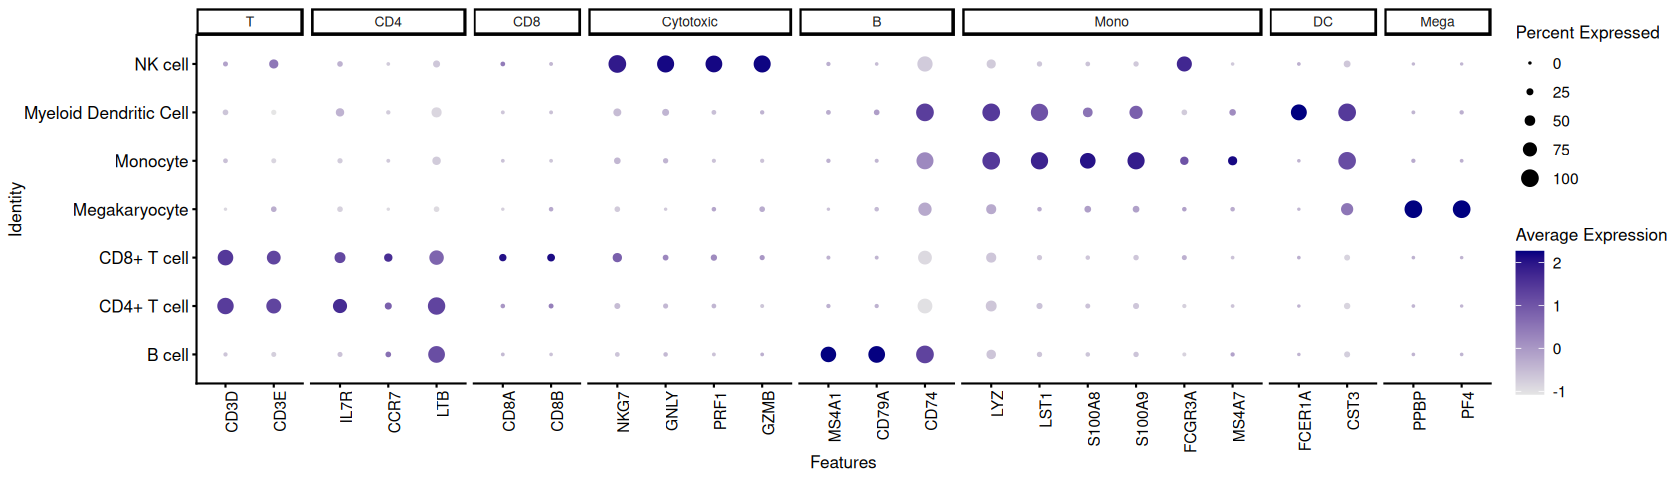

In [16]:
options(repr.plot.width = 14, repr.plot.height = 4)

DefaultAssay(pbmc) <- "RNA"
genes_in <- rownames(pbmc)

resolve_gene <- function(g, genes) {
  if (g %in% genes) return(g)
  hit <- grep(paste0("^", g, "([\\.-].+)?$"), genes, value = TRUE)
  if (length(hit) > 0) return(hit[1])
  return(NA_character_)
}

markers_grp <- list(
  "T"         = c("TRAC","CD3D","CD3E"),
  "CD4"       = c("IL7R","CCR7","LTB"),
  "CD8"       = c("CD8A","CD8B"),
  "Cytotoxic" = c("NKG7","GNLY","PRF1","GZMB"),
  "B"         = c("MS4A1","CD79A","CD74"),
  "Mono"      = c("LYZ","LST1","S100A8","S100A9","FCGR3A","MS4A7"),
  "DC"        = c("FCER1A","CST3"),
  "Mega"      = c("PPBP","PF4")
)

# Remove missing genes + prevent duplicates across groups (avoids factor-level errors)
filter_markers <- function(marker_list, genes) {
  used <- character(0)
  out <- list()
  for (nm in names(marker_list)) {
    gs <- marker_list[[nm]]
    gs2 <- vapply(gs, resolve_gene, character(1), genes = genes)
    gs2 <- unique(na.omit(gs2))
    gs2 <- gs2[!gs2 %in% used]
    used <- c(used, gs2)
    if (length(gs2) > 0) out[[nm]] <- gs2
  }
  out
}

markers3 <- filter_markers(markers_grp, genes_in)

pbmc$Curated_CellType[is.na(pbmc$Curated_CellType)] <- "Unknown"
Idents(pbmc) <- pbmc$Curated_CellType

p <- DotPlot(
  pbmc,
  features = markers3,
  group.by = "Curated_CellType",
  dot.scale = 4,
  cols = c("grey90", "navy")
) + RotatedAxis()

p + theme_classic(base_size = 10) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, size = 9),
    axis.text.y = element_text(size = 10),
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 9)
  )

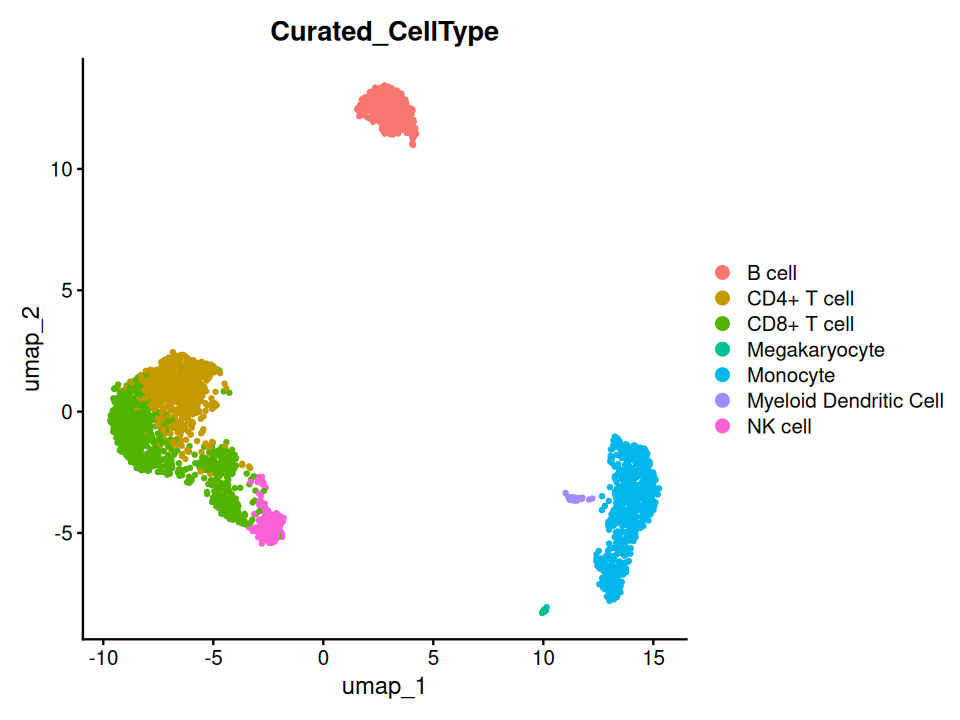

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(pbmc, group.by = "Curated_CellType")